# Saving and loading data



In [1]:
import pickle
import warnings
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from plotnine.data import diamonds

warnings.simplefilter(action="ignore", category=UserWarning)

RANDOM_SEED = 123

In [2]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
with pm.Model() as m1:
    # Priors
    alpha = pm.Normal("alpha", 0, 5)
    beta = pm.Normal("beta", 0, 2)

    # Model
    mu = pm.Deterministic("mu", alpha + beta * diamonds.x)
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    carat = pm.Normal("carat", mu, sigma, observed=diamonds.carat)

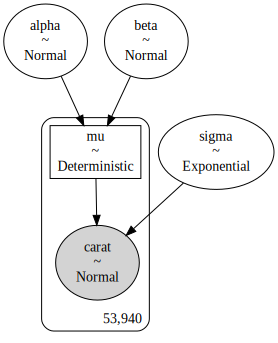

In [4]:
pm.model_to_graphviz(m1)

> **The following functions have been copied to "pymc3_helpers.py".**

In [8]:
def write_pickle(x, fp):
    """Write `x` to disk as a pickle file."""
    with open(fp, "wb") as f:
        pickle.dump(x, f)
    return None


def get_pickle(fp):
    """Read a pickled file into Python."""
    with open(fp, "rb") as f:
        d = pickle.load(f)
    return d


def pymc3_sampling_procedure(
    model,
    num_mcmc=1000,
    tune=1000,
    chains=2,
    cores=None,
    prior_check_samples=1000,
    ppc_samples=1000,
    random_seed=1234,
    cache_dir=None,
    force=False,
):
    """
    Run the standard PyMC3 sampling procedure.

        Parameters:
            model(pymc3 model): A model from PyMC3
            num_mcmc(int): number of MCMC samples
            tune(int): number of MCMC tuning steps
            chains(int): number of of MCMC chains
            cores(int): number of cores for MCMC
            prior_check_samples(int): number of prior predictive samples to take
            ppc_samples(int): number of posterior predictive samples to take
            random_seed(int): random seed to use in all sampling processes
            cache_dir(Path): the directory to cache the output (leave as `None` to skip caching)
            force(bool): ignore cached results and compute trace and predictive checks
        Returns:
            dict: contains the "trace", "posterior_predictive", and "prior_predictive"
    """
    if cache_dir is not None:
        post_file_path = cache_dir / "posterior-predictive-check.pkl"
        prior_file_path = cache_dir / "prior-predictive-check.pkl"

    if not force and cache_dir is not None and cache_dir.exists():
        print("Loading cached trace and posterior sample...")
        trace = pm.load_trace(cache_dir.as_posix(), model=model)
        post_check = get_pickle(post_file_path)
        prior_check = get_pickle(prior_file_path)
    else:
        with model:
            prior_check = pm.sample_prior_predictive(
                prior_check_samples, random_seed=random_seed
            )
            trace = pm.sample(
                num_mcmc, tune=tune, random_seed=random_seed, chains=chains, cores=cores
            )
            post_check = pm.sample_posterior_predictive(
                trace, samples=ppc_samples, random_seed=random_seed
            )
        if cache_dir is not None:
            print("Caching trace and posterior sample...")
            pm.save_trace(m1_trace, directory=m1_save_dir, overwrite=True)
            write_pickle(post_check, post_file_path)
            write_pickle(prior_check, prior_file_path)
    return {
        "trace": trace,
        "posterior_predictive": post_check,
        "prior_predictive": prior_check,
    }

In [ ]:
m1_save_dir = Path("pymc3_model_cache/m1")

m1_results = pymc3_sampling_procedure(m1, cache_dir=m1_save_dir)
az_m1 = az.from_pymc3(
    model=m1,
    trace=m1_results["trace"],
    posterior_predictive=m1_results["posterior_predictive"],
    prior=m1_results["prior_predictive"],
)

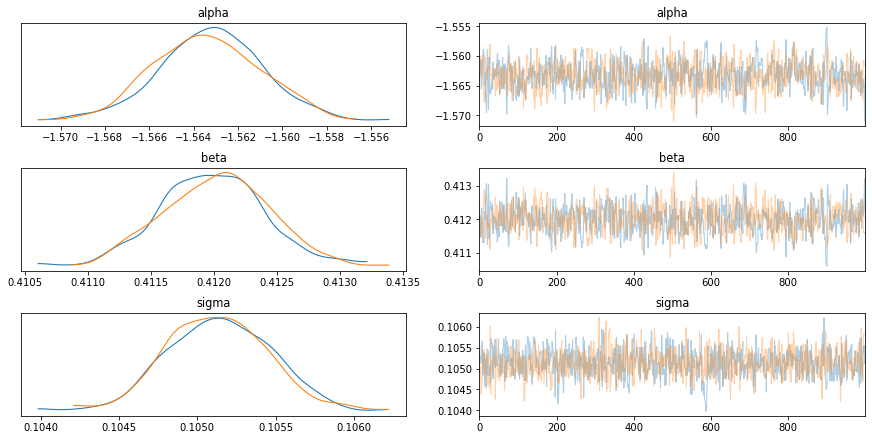

In [6]:
az.plot_trace(az_m1, var_names=["alpha", "beta", "sigma"])
plt.show()